my first notebook

thank you DANIIL KARPOV https://www.kaggle.com/code/vanguarde/h-m-eda-first-look for giving me all the inspiration

## **<span style="color:#008000;font-size:490%"><center>EDA</center></span><span style="color:#008000;font-size:200%"><center>Exploratory Data Analysis. H&M</center></span>**

# Introduction

For this challenge you are given the purchase history of customers across time, along with supporting metadata. Your challenge is to predict what articles each customer will purchase in the 7-day period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring.


The dataset contains 4 csv files and one folder with several subfolders, each with a different number of images.

In this Exploratory Data Analysis Notebook we will look to the data, will analyze the content of each csv file, check for missing data, understand the data distribution, see what are the relations between data in various files.

We will also explore the image data, understand how images are indexed in the csv files, if there are articles in the dataset without images. We will also explore image additional information, like image width and height.

We also investigate a very simple baseline model and create an initial submission.

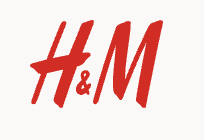

# Analysis preparation

We will include here the required packages for reading, parsing, filtering, processing, visualizing the data, both tabular and image.

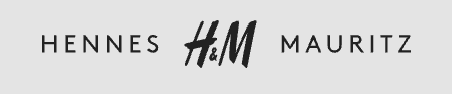


In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from PIL import Image
from plotnine import *

In [ ]:
articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

### first lets go through the articles that is selling on H&M

In [ ]:
len(articles.columns)

So we have in total of 25 columns. What are they?

In [ ]:
articles.columns

article_id : A unique identifier of every article.

product_code, prod_name : A unique identifier of every product and its name (not the same).

product_type, product_type_name : The group of product_code and its name

graphical_appearance_no, graphical_appearance_name : The group of graphics and its name

colour_group_code, colour_group_name : The group of color and its name

perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name : The added color info

department_no, department_name: : A unique identifier of every dep and its name

index_code, index_name: : A unique identifier of every index and its name

index_group_no, index_group_name: : A group of indeces and its name

section_no, section_name: : A unique identifier of every section and its name

garment_group_no, garment_group_name: : A unique identifier of every garment and its name

detail_desc: : Details

I notice that all of the data here is categorical / index for each feature. 

So Let's do some question and answer style to think about this data!

So what product do we have here

In [ ]:
articles.columns

In [ ]:
product_count = pd.DataFrame(articles[['product_code']].value_counts().sort_values(ascending=False),columns = ['count'])
product_count = product_count.reset_index()

In [ ]:
product_count.describe()

By looking at product code, we can see top one percent of product have multiple different variation. Like \#1 most count of product is actually kid clothing!
Whereas the 90% of the product is only average of 1-2 variation. 

From here we can note that the same product can have variation. 

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(product_count.index[:1000],product_count['count'][:1000])
plt.ylim([0, 100])
plt.show()

In [ ]:
product_name = articles[['product_code','prod_name']]

In [ ]:
product_name.drop_duplicates()

In [ ]:
product_count.merge(product_name, how = "left", left_on="product_code",right_on="product_code").sort_values(by='count')

I notice the most repeated product is kid clothing!

prod_name can be really creative, and can definitely contribute later. For now, I may skip this variable. 

Now I can ask a better question, So what product type do we have here?

In [ ]:
product_type = articles[['product_code', 'product_type_no','product_type_name']]

In [ ]:
product_type_name = articles[['product_type_no','product_type_name']]
product_type_name = product_type_name.drop_duplicates()

we have 132 unique type in all our articles. Lets see how they are distributed!

In [ ]:
product_type = pd.DataFrame(product_type.groupby(by=["product_type_no"])['product_type_name'].count().sort_values(ascending=False))
product_type = product_type.reset_index()
product_type.columns = ['product_type_no', 'product_type_count']

In [ ]:
product_type

In [ ]:
type_no_to_name = dict(zip(product_type_name['product_type_no'],product_type_name['product_type_name']))

In [ ]:
product_type

In [ ]:
product_type['product_type_name'] = product_type['product_type_no'].apply(lambda x : type_no_to_name[x]) 

In [ ]:
product_type

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(product_type['product_type_name'][:20],product_type['product_type_count'][:20])
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
plt.pie(product_type['product_type_count'], labels = product_type['product_type_name'])
plt.show()

Trouser dress sweater is hily skewed Since they take up more than 40% of articles in H&M

In [ ]:
product_type['product_type_count'].sum()

In [ ]:
# calculate the percentage of top 5 in all the articles

product_type[product_type['product_type_name'].isin(['Top','T-shirt','Sweater','Dress','Trousers'])]['product_type_count'].sum() / product_type['product_type_count'].sum()

Above I was exploring what type of articles do we have. And I found that that top 5 most provided type,'Top','T-shirt','Sweater','Dress','Trousers' takes up 40% of the articles sound at H&M. That's crazy! I didn't think it will be highly skewed like this in the articles!

In [ ]:
articles.columns

In [ ]:
product_group = pd.DataFrame(articles[['article_id','product_group_name']].groupby('product_group_name')['article_id'].count().sort_values(ascending=False))
product_group = product_group.reset_index()
product_group.columns = ['product_group_name','count']
product_group

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(product_group['product_group_name'],product_group['count'])
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
plt.pie(product_group['count'], labels = product_group['product_group_name'])
plt.show()

So far we have looked at data from 1 dimension. Now lets increase the dimension and explore more!

In [ ]:
articles.groupby(['product_group_name','index_name'])['article_id'].count().sort_values()

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='product_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

### I definitley notice *lady and children* is dominating almost all the garment group. 

In [ ]:
articles.groupby(['product_group_name', 'product_type_name']).count()['article_id'].get("Accessories").sort_values()

Since now we have some understanding of Articles, aka most of the stuff are for female and children. 

we can give a look at Customers and check if there is any interesting finding!

In [ ]:
# missing data percentage
customers.isna().sum() / customers.shape[0]

In [ ]:
# since its hard to know what age just base on this, we may omit and try guess their age base on what they buy ?

age_na_cus = customers.age.isna()

# kept the one that has age 

customers_age = customers[age_na_cus.apply(lambda x : not x)]

lets check out the distribution of age.

In [ ]:
customers_age = customers_age.sort_values(by='age',ascending=False)

In [ ]:
customers_age

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_age, x='age', bins=20, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

Not much for customer data besides their age, news, and club member status

now i want to find out maybe how much the same customer spend by monthly in 2019/9/22 - 2020/9/22. 

In [ ]:
transactions = transactions.sort_values(['customer_id'])

In [ ]:
transactions.t_dat

In [ ]:
transactions.describe()

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=transactions, x='price', bins=100, color='orange')
ax.set_xlabel('Distribution of the customer spending')
plt.xlim([0,0.2])
plt.show()

In [ ]:
transactions.groupby('customer_id')

In [ ]:
last_year_tran = transactions[transactions['t_dat'] >= '2019-09-22']

In [ ]:
last_year_tran.t_dat = pd.to_datetime(last_year_tran.t_dat)

In [ ]:
last_year_tran['month'] = last_year_tran.t_dat.apply(lambda x : x.month)

# import cudf
# train = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
# train['customer_id'] = train['customer_id'].str[-16:].str.hex_to_int().astype('int64')
# train['article_id'] = train.article_id.astype('int32')
# train.t_dat = cudf.to_datetime(train.t_dat)
# train = train[['t_dat','customer_id','article_id']]
# train.to_parquet('train.pqt',index=False)
# print( train.shape )
# train.head()

How many unique customer made purchase in 2022?

In [ ]:
last_year_tran['customer_id'].nunique()

**<span style="color:#008000;"> Let's see the general summary about the transaction</span>**

So I want to see what is the totoal number of item from each customer for last year of transaction. 

In [ ]:
cus_bought_count = pd.DataFrame(last_year_tran.groupby('customer_id')['article_id'].count().sort_values(ascending=False))

In [ ]:
last_year_tran

In [ ]:
cus_bought_count = cus_bought_count.reset_index()
cus_bought_count.columns = ['customer_id','article_count']

In [ ]:
cus_bought_count.describe()

Since I noticed huge discrepency between people who are top 10% of customer and rest of 90%

I may want to consider top 10 to be loyal customer as average of them purchase at least 2-3 item every month.

while the rest of 90% make occasional purchases. 

In [ ]:
cus_bought_count[cus_bought_count['article_count'] >= 36]['article_count'].describe()

In [ ]:
cus_bought_count[cus_bought_count['article_count'] < 36]['article_count'].describe()

Now I have a business related question, top 10% customer is responsible for how much % of revenue in last year?


In [ ]:
cus_spent = pd.DataFrame(last_year_tran.groupby('customer_id')['price'].sum().sort_values(ascending=False)).reset_index()

In [ ]:
cus_spent.head(2)

In [ ]:
top_10 = cus_bought_count[cus_bought_count['article_count'] >= 36]

In [ ]:
top_10_count_spent = top_10.merge(cus_spent, how='left', left_on='customer_id',right_on='customer_id')

In [ ]:
top_10_count_spent.sample(3)

In [ ]:
top_10_count_spent.price.sum() / last_year_tran.price.sum()

After some digging, I find out top 10% of the customer is responsible for 45% of sale in 2022.

If I was the CEO, I will be really sure those 10% of cusotmer get best possible experience to maintain relationship with them. 

In [ ]:
plt.boxplot(cus_bought_count['article_count'])

Now I want to know what items have the customer bought throughout the entire year. Can be guess about their spending behavior and potentially age and gender?

In [ ]:
#I will start with top 10% customers. Aka loyal customers.
top_10.head(1)

I am going to explore what has our \#1 customer has bought for the last year, as this customer bought 1020 items in the last year. 

In [ ]:
number_1 = last_year_tran[last_year_tran['customer_id'] == top_10.head(1)['customer_id'].values[0]]

In [ ]:
articles.head(3)


In [ ]:
stuff_number1_bought = number_1.merge(articles, how = 'left', left_on = 'article_id', right_on = 'article_id')

In [ ]:
articles['product_group_name'].head(2)

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=stuff_number1_bought, y='product_group_name', color='orange', hue='index_name', multiple="stack")
# ax.set_xlabel('count by garment group')
# ax.set_ylabel('garment group')
plt.show()

From my understanding, Divided is also mainly female clothing. 

In [ ]:
customers.head(2)

In [ ]:
stuff_number1_bought.head(3)

In [ ]:
customers[customers['customer_id'] == top_10.head(1)['customer_id'].values[0]]